In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
import numpy as np
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

# File paths
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
CPG_OXID = "../data_normalized/cpg_Normalized.csv"
BIN_OXID = "../data_normalized/cleaned_Normalized_1000.csv"
LIST = [
    "../data_anova/cpg/cpg_overlap_genes_result.bed",
    "../data_anova/bin1000/overlap_genes_result.bed",
    "../data_anova/bin1000/overlap_promoters_result.bed"
]

# Create output directory for plots
output_dir = Path("../images/gene_correlation_plots")
output_dir.mkdir(exist_ok=True)

# Function to extract group from sample name
def extract_group_expr(sample):
    # Expected format: '20_CRS_evening'
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    # Expected format: 'Sample_14_CRS_evening_S14_'
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

# Load data
def load_data():
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading CpG oxidation data...")
    cpg_df = pd.read_csv(CPG_OXID)
    
    print("Loading bin oxidation data...")
    bin_df = pd.read_csv(BIN_OXID)
    
    # Process expression data
    # Add group column based on Sample column
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    print (expr_df.head(5))
    
    # Process oxidation data
    # Add group column based on sample name
    cpg_df['Group'] = cpg_df['sample'].apply(extract_group_oxid)
    bin_df['Group'] = bin_df['Sample'].apply(extract_group_oxid)
    
    return expr_df, cpg_df, bin_df

# Load gene lists from BED files
def load_gene_lists():
    all_genes = []
    for list_file in LIST:
        try:
            print(f"Loading genes from {list_file}...")
            # Read BED file, assuming genes are in the 10th column (index 9)
            df = pd.read_csv(list_file, sep='\t', header=None)
            
            # Get genes from the 10th column
            genes = df.iloc[:, 9].tolist()
            ids = df.iloc[:, 3].tolist()
            
            # Keep track of which file each gene came from
            file_name = os.path.basename(list_file)
            gene_data = [(gene, id_val, file_name) for gene, id_val in zip(genes, ids)]
            all_genes.extend(gene_data)
      
            
            print(f"Found {len(genes)} unique genes in {file_name}")
        except Exception as e:
            print(f"Error loading {list_file}: {e}")
    
    return all_genes

# Function to create scatter plot for a gene
def plot_gene_correlation(gene, ID, source_file, expr_df, cpg_df, bin_df):
    print(f"Processing gene: {gene} with id: {ID} from {source_file}")
    
    # Determine which oxidation data to use based on source file
    if "cpg" in source_file:
        oxid_df = cpg_df
        oxid_col = "median_normalized_damage"
        oxid_df['bin_id'] = oxid_df['id'].astype(str) + oxid_df['strand']
        oxid_id_col = "bin_id"
        oxid_type = "CpG"
    else:  # bin1000
        oxid_df = bin_df
        oxid_col = "Median_Normalized_Damage"
        oxid_df['bin_id'] = oxid_df['Bin'].astype(str) + '_' + oxid_df['Strand'] + oxid_df['Chromosome'].astype(str)
        oxid_id_col = "bin_id"
        oxid_type = "Bin1000"
    
    
    gene_expr = expr_df[expr_df['Gene'] == gene]

    if gene_expr.empty:
        print(f"No expression data found for gene {gene}")
        return
    
    # Find corresponding oxidation data entries
    # This is a simplification - you may need to adjust how to match gene to oxidation IDs

    gene_oxid = oxid_df[oxid_df[oxid_id_col] == ID]

    if gene_oxid.empty:
        print(f"No oxidation data found for gene {gene}")
        return
    
    # Prepare data for plotting by matching samples
    plot_data = []
    
    for group in ['CRS_evening', 'CRS_morning', 'Ctrl_evening', 'Ctrl_morning']:
        # Get expression values for this group
        group_expr = gene_expr[gene_expr['Group'] == group]
        
        # Get oxidation values for this group
        group_oxid = gene_oxid[gene_oxid['Group'] == group]
        
        # Combine data from both sources
        # Here we're assuming each group has 5 samples as mentioned in your description
        for i in range(min(len(group_expr), len(group_oxid))):
            try:
                expr_value = group_expr.iloc[i]['Expression_level']
                oxid_value = group_oxid.iloc[i][oxid_col]
                
                plot_data.append({
                    'Expression': expr_value,
                    'Oxidation': oxid_value,
                    'Group': group
                })
            except IndexError:
                continue
    
    # Create DataFrame from collected data
    if not plot_data:
        print(f"No matching data points found for gene {gene}")
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with color-coded groups
    sns.scatterplot(
        data=plot_df, 
        x='Expression', 
        y='Oxidation', 
        hue='Group', 
        palette='tab10',
        s=100,
        alpha=0.7
    )
    
    # Add trend line for all data
    if len(plot_df) > 1:
        sns.regplot(
            data=plot_df, 
            x='Expression', 
            y='Oxidation', 
            scatter=False, 
            line_kws={"color": "red", "linestyle": "--"}
        )
    
    # Calculate correlation
    correlation = plot_df['Expression'].corr(plot_df['Oxidation'])
    
    # Add title and labels
    plt.title(f'Gene: {gene} (r = {correlation:.3f})\nOxidation Type: {oxid_type}', fontsize=14)
    plt.xlabel('Gene Expression Level (TPM)', fontsize=12)
    plt.ylabel(f'Oxidation Level ({oxid_col})', fontsize=12)
    
    # Add legend
    plt.legend(title='Group', fontsize=10)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save plot
    output_path = output_dir / f"{gene}_{oxid_type}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {output_path}")
    
    return correlation



In [11]:
# Load all data
expr_df, cpg_df, bin_df = load_data()

Loading expression data...
Loading CpG oxidation data...
Loading bin oxidation data...
   Unnamed: 0                Gene  Expression_level           Sample  \
0           0  ENSMUSG00000000001         15.613475  01_Ctrl_morning   
1           1  ENSMUSG00000000003          0.000000  01_Ctrl_morning   
2           2  ENSMUSG00000000028          0.775004  01_Ctrl_morning   
3           3  ENSMUSG00000000031          0.099366  01_Ctrl_morning   
4           4  ENSMUSG00000000037          0.403567  01_Ctrl_morning   

          Group  
0  Ctrl_morning  
1  Ctrl_morning  
2  Ctrl_morning  
3  Ctrl_morning  
4  Ctrl_morning  


In [12]:
# Load gene lists
gene_list = load_gene_lists()

Loading genes from ../data_anova/cpg/cpg_overlap_genes_result.bed...
Found 2 unique genes in cpg_overlap_genes_result.bed
Loading genes from ../data_anova/bin1000/overlap_genes_result.bed...
Found 11 unique genes in overlap_genes_result.bed
Loading genes from ../data_anova/bin1000/overlap_promoters_result.bed...
Found 1 unique genes in overlap_promoters_result.bed


Processing 14 genes...
Processing gene: ENSMUSG00000120306 with id: NC_000070.7_55651120+ from cpg_overlap_genes_result.bed


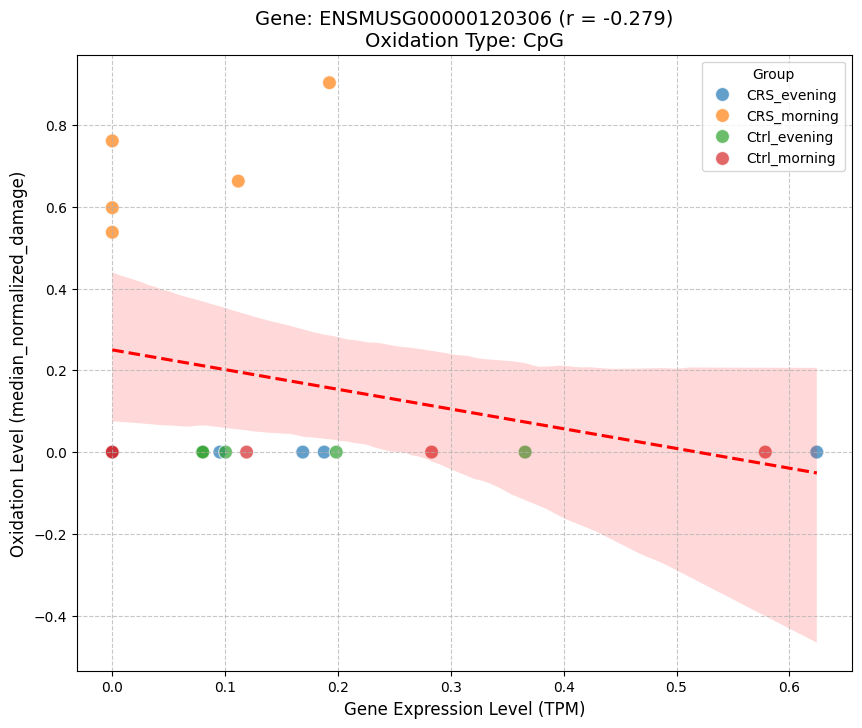

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000120306_CpG.png
Processing gene: ENSMUSG00000022577 with id: NC_000081.7_75438313+ from cpg_overlap_genes_result.bed


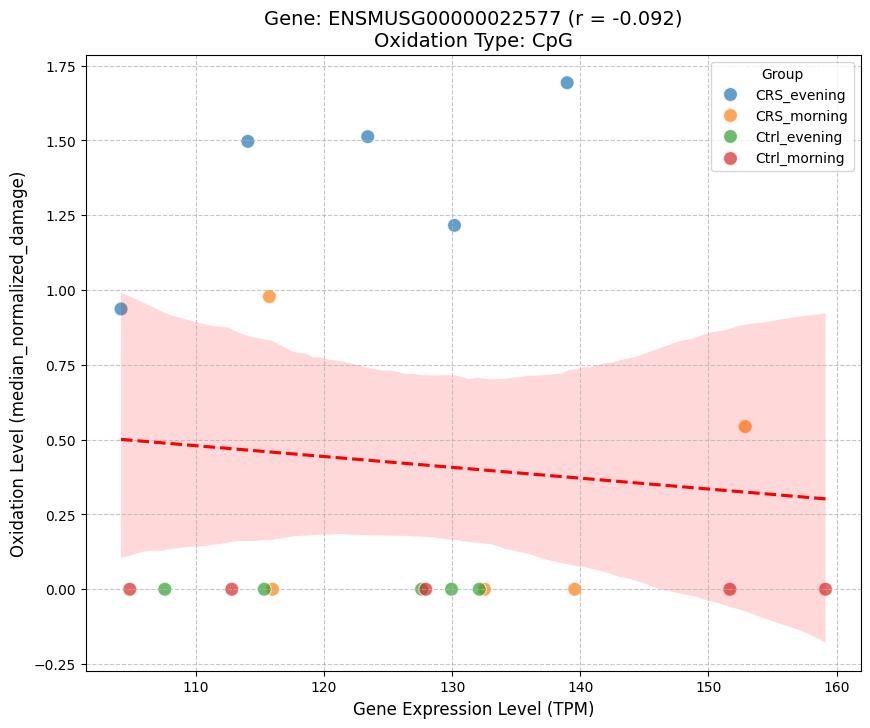

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000022577_CpG.png
Processing gene: ENSMUSG00000018654 with id: 11648000.0_-NC_000077.7 from overlap_genes_result.bed


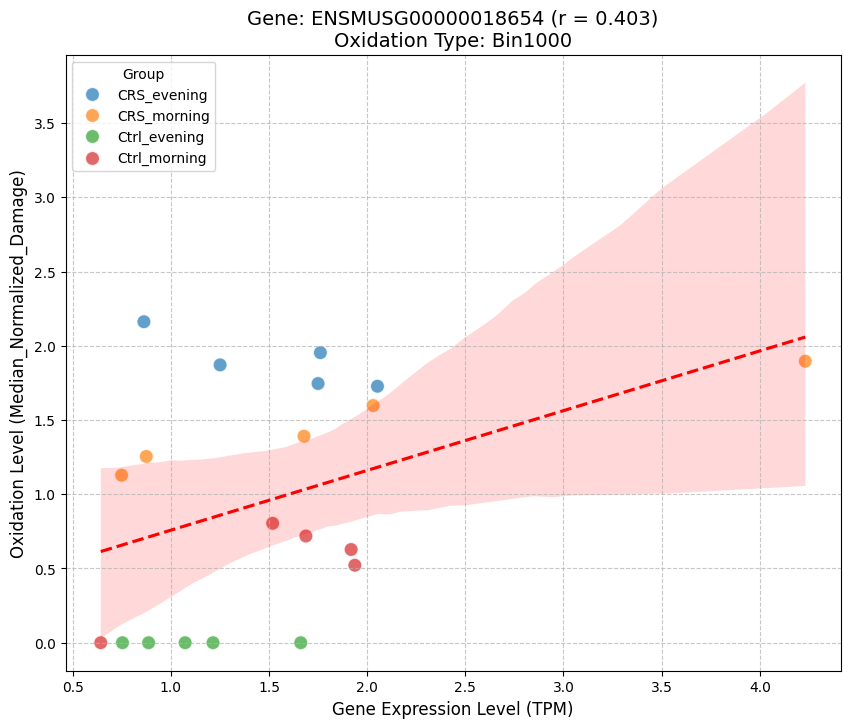

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000018654_Bin1000.png
Processing gene: ENSMUSG00000004568 with id: 3460000.0_-NC_000074.7 from overlap_genes_result.bed


IOStream.flush timed out


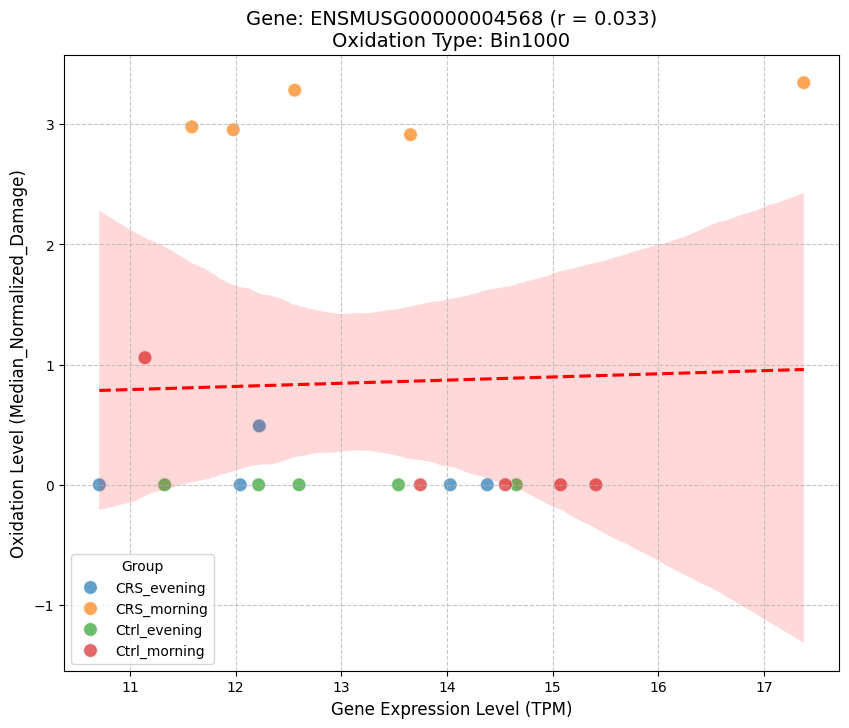

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000004568_Bin1000.png
Processing gene: ENSMUSG00000101574 with id: 184275000.0_+NC_000067.7 from overlap_genes_result.bed


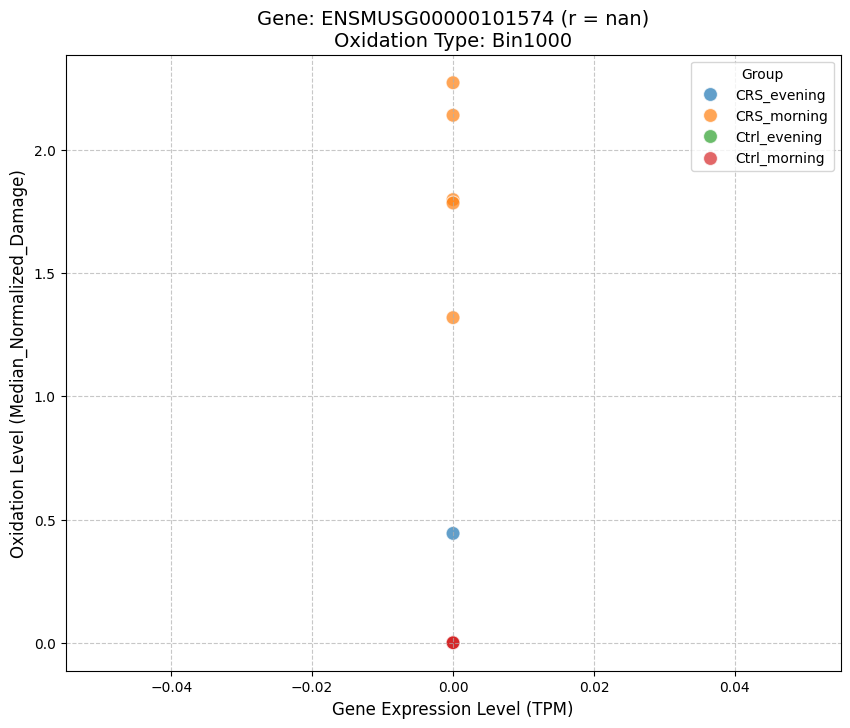

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000101574_Bin1000.png
Processing gene: ENSMUSG00000069170 with id: 81642000.0_-NC_000079.7 from overlap_genes_result.bed


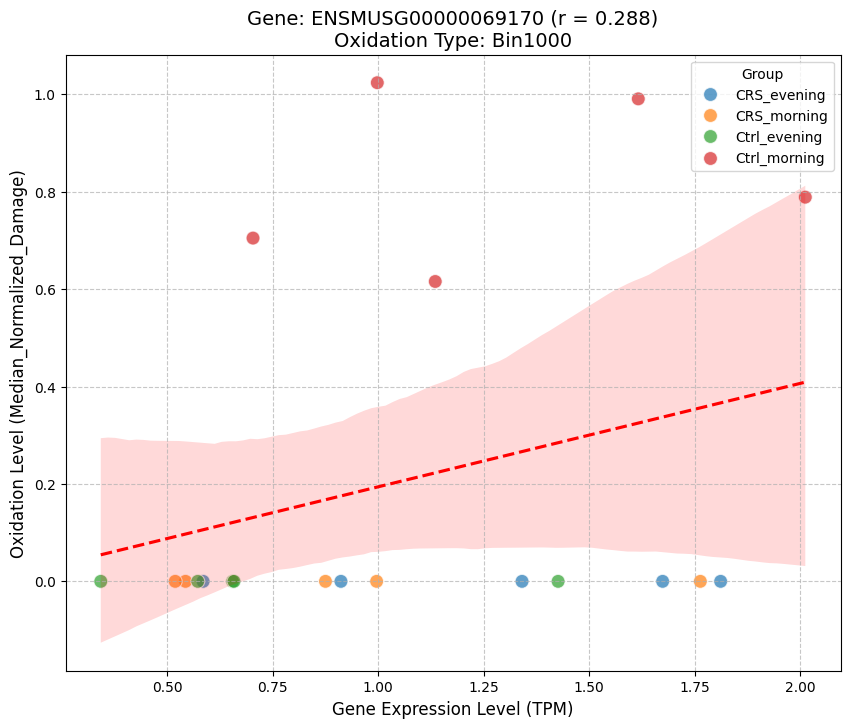

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000069170_Bin1000.png
Processing gene: ENSMUSG00000040693 with id: 96747000.0_+NC_000067.7 from overlap_genes_result.bed


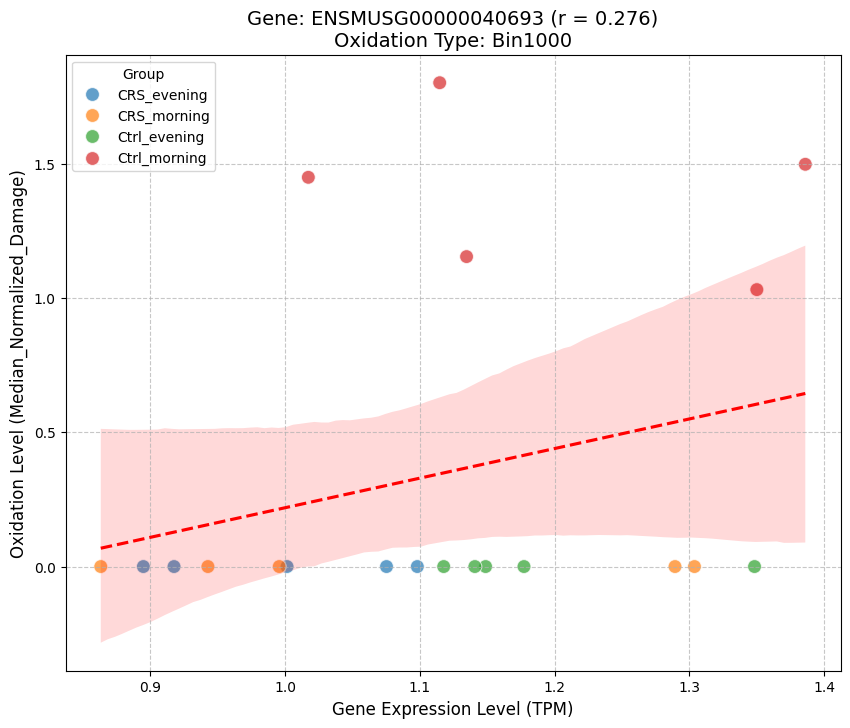

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000040693_Bin1000.png
Processing gene: ENSMUSG00000097207 with id: 22988000.0_+NC_000071.7 from overlap_genes_result.bed


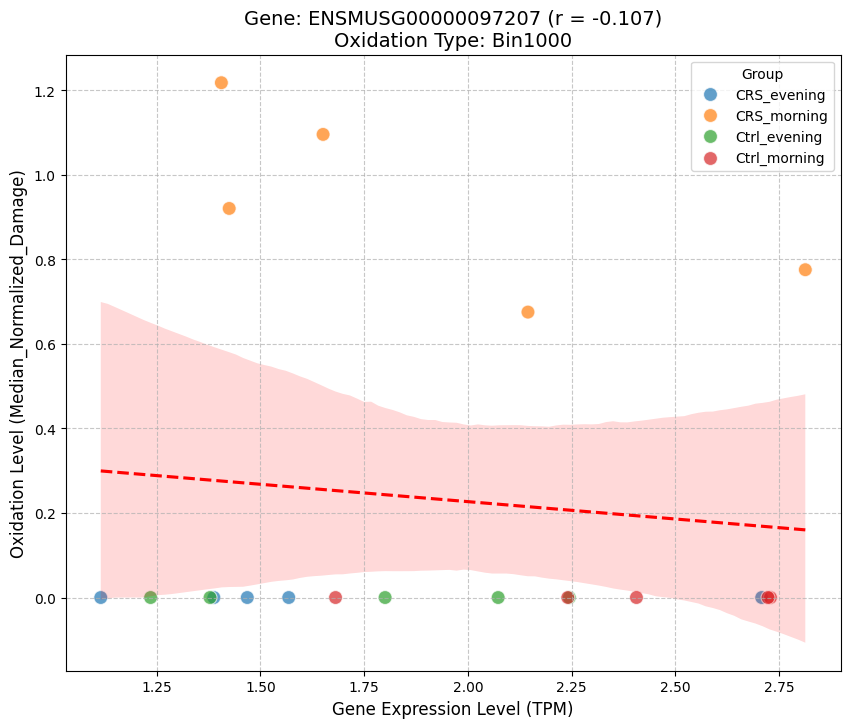

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000097207_Bin1000.png
Processing gene: ENSMUSG00000106379 with id: 22988000.0_+NC_000071.7 from overlap_genes_result.bed


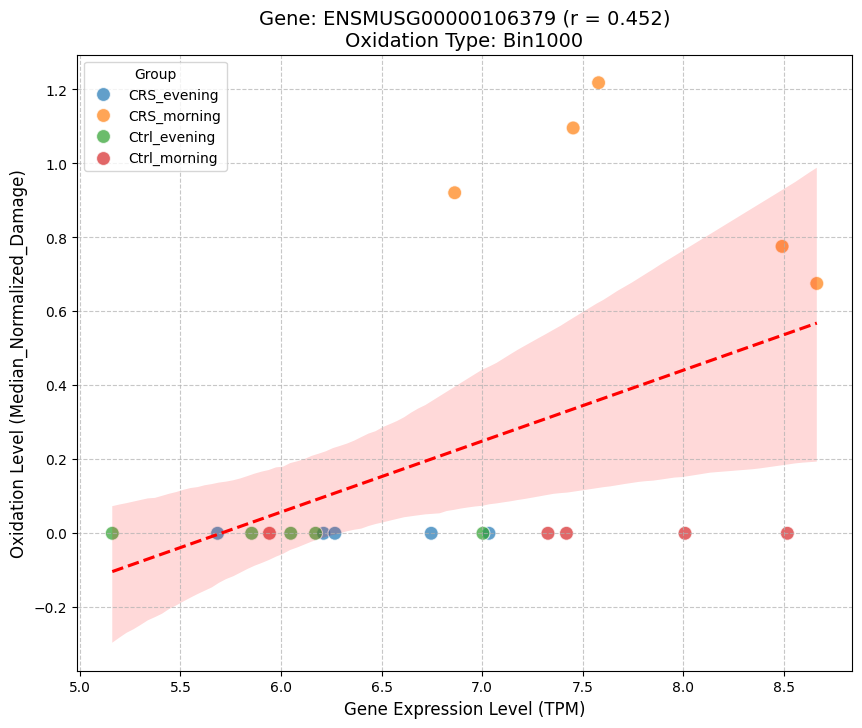

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000106379_Bin1000.png
Processing gene: ENSMUSG00000111399 with id: 103296000.0_-NC_000075.7 from overlap_genes_result.bed


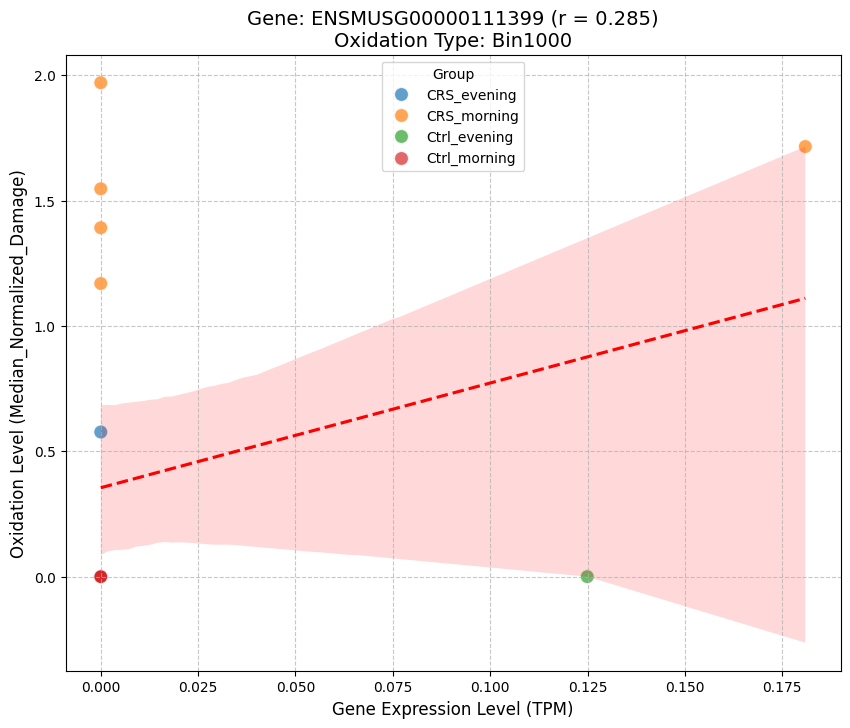

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000111399_Bin1000.png
Processing gene: ENSMUSG00000033769 with id: 84831000.0_+NC_000072.7 from overlap_genes_result.bed


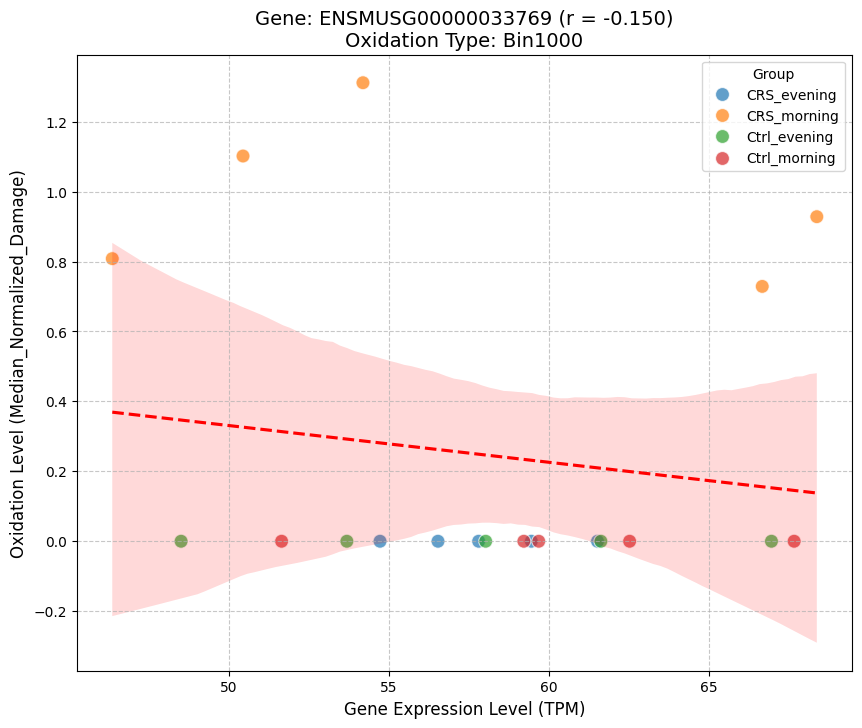

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000033769_Bin1000.png
Processing gene: ENSMUSG00000062687 with id: 85887000.0_-NC_000074.7 from overlap_genes_result.bed


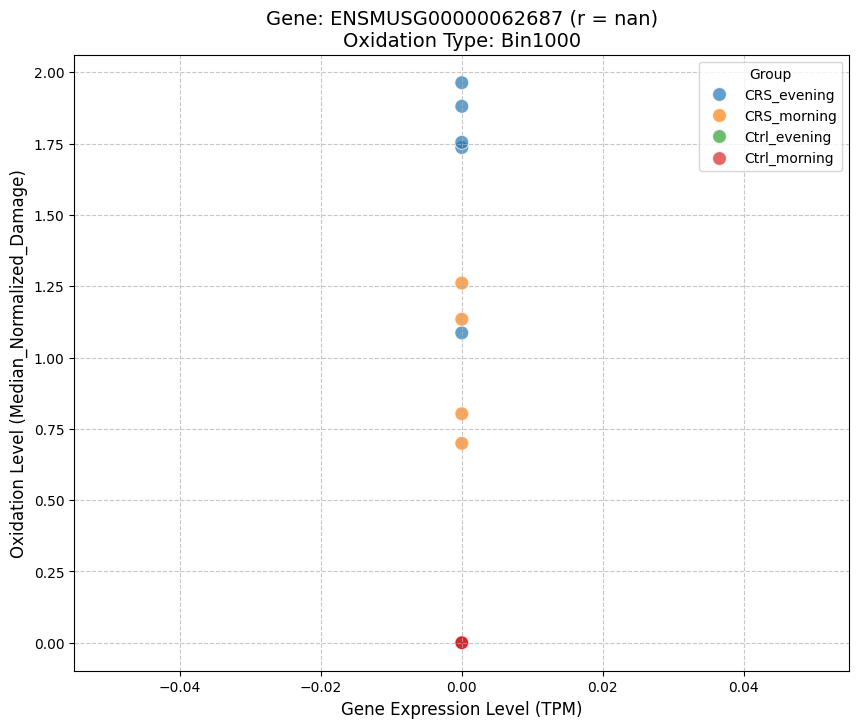

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000062687_Bin1000.png
Processing gene: ENSMUSG00000056023 with id: 81825000.0_+NC_000069.7 from overlap_genes_result.bed


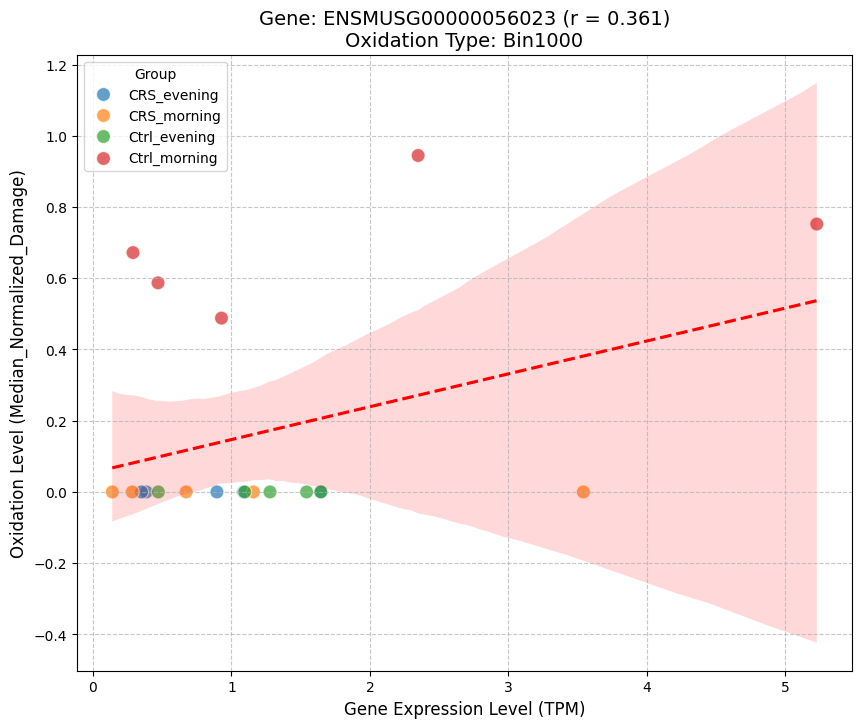

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000056023_Bin1000.png
Processing gene: ENSMUSG00000073145 with id: 11648000.0_-NC_000077.7 from overlap_promoters_result.bed


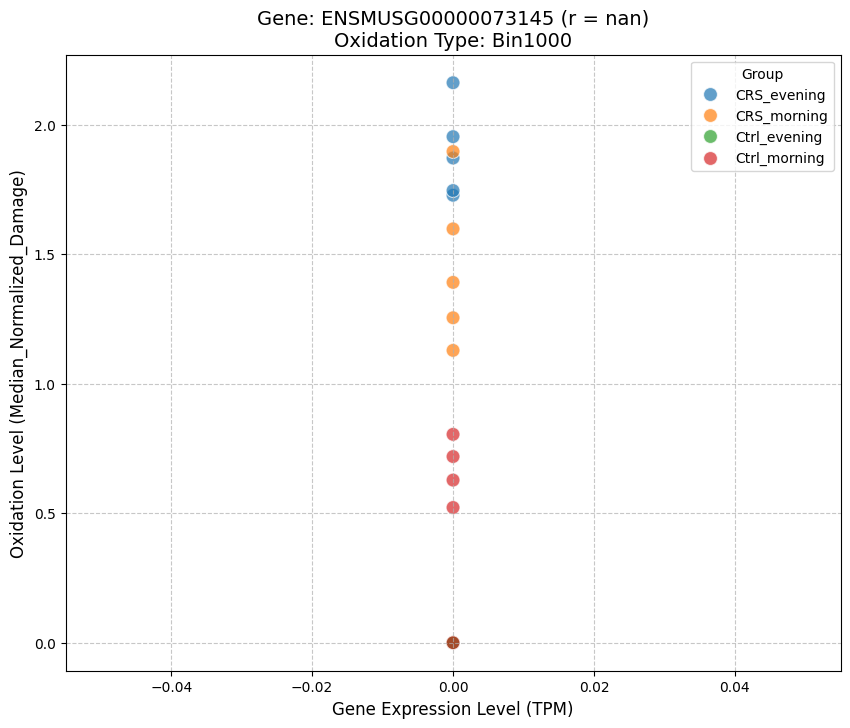

Plot saved to ../images/gene_correlation_plots/ENSMUSG00000073145_Bin1000.png


In [13]:
print(f"Processing {len(gene_list)} genes...")
# Create a DataFrame to store correlation results
results = []
        
# Process each gene
for gene, ID, source_file in gene_list:
    try:
        corr = plot_gene_correlation(gene, ID, source_file, expr_df, cpg_df, bin_df)
          
        if corr is not None:
            results.append({
                'Gene': gene,
                'Source': source_file,
                'Correlation': corr
            })
    except Exception as e:
        print(f"Error processing gene {gene}: {e}")

In [14]:
#This is for the promoter data as they already have corresponding genes

# File paths
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
PROMOTER_OXID = "../data_normalized/promoters_Normalized.csv"
SIGNIFICANT_BINS = "../data_anova/promoters/anova_all_significant_bins.csv"

# Create output directory for plots
output_dir = Path("../images/significant_gene_correlation_plots")
output_dir.mkdir(exist_ok=True)

# Function to extract group from sample name
def extract_group_expr(sample):
    # Expected format: '20_CRS_evening'
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    # Expected format: 'Sample_14_CRS_evening_S14_'
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def extract_gene_and_strand(bin_id):
    """Extract gene ID and strand from bin_id (e.g., 'ENSMUSG00000104528+' -> ('ENSMUSG00000104528', '+'))"""
    if bin_id.endswith('+') or bin_id.endswith('-'):
        return bin_id[:-1], bin_id[-1]
    return bin_id, None

# Load data
def load_data():
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading promoter oxidation data...")
    promoter_df = pd.read_csv(PROMOTER_OXID)
    
    print("Loading significant bins data...")
    sig_bins_df = pd.read_csv(SIGNIFICANT_BINS)
    
    # Process expression data
    # Add group column based on Sample column
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    print("Expression data sample:")
    print(expr_df.head(5))
    
    # Process oxidation data
    # Add group column based on sample name
    promoter_df['Group'] = promoter_df['sample'].apply(extract_group_oxid)
    print("\nPromoter oxidation data sample:")
    print(promoter_df.head(5))
    
    print("\nSignificant bins data:")
    print(sig_bins_df.head())
    
    return expr_df, promoter_df, sig_bins_df

# Load gene information from significant bins
def load_significant_genes(sig_bins_df):
    significant_genes = []
    
    for _, row in sig_bins_df.iterrows():
        bin_id = row['bin_id']
        gene_id, strand = extract_gene_and_strand(bin_id)
        
        significant_genes.append({
            'gene_id': gene_id,
            'strand': strand,
            'bin_id': bin_id,
            'most_significant_factor': row['most_significant_factor'],
            'max_f_value': row['max_f_value'],
            'significant_factors': row['significant_factors']
        })
        
        print(f"Found significant gene: {gene_id} (strand: {strand})")
    
    return significant_genes

# Function to create scatter plot for a gene
def plot_gene_correlation(gene_info, expr_df, promoter_df):
    gene_id = gene_info['gene_id']
    strand = gene_info['strand']
    bin_id = gene_info['bin_id']
    
    print(f"Processing gene: {gene_id} (strand: {strand})")
    
    # Find expression data for this gene
    # Note: You may need to adjust this depending on how gene IDs are stored in your expression data
    # The expression data might use a different gene identifier format
    gene_expr = expr_df[expr_df['Gene'] == gene_id]
    
    if gene_expr.empty:
        # Try alternative matching - sometimes gene IDs might be in different formats
        print(f"No direct match found for {gene_id}, checking for partial matches...")
        # You might need to implement fuzzy matching or use gene name instead of ID
        return None
    
    # Find corresponding oxidation data entries
    # Match by gene ID and strand (using separate columns)
    gene_oxid = promoter_df[
        (promoter_df['id'] == gene_id) & 
        (promoter_df['strand'] == strand)
    ]
    
    if gene_oxid.empty:
        print(f"No oxidation data found for gene {gene_id} with strand {strand}")
        return None
    
    # Prepare data for plotting by matching samples
    plot_data = []
    
    for group in ['CRS_evening', 'CRS_morning', 'Ctrl_evening', 'Ctrl_morning']:
        # Get expression values for this group
        group_expr = gene_expr[gene_expr['Group'] == group]
        
        # Get oxidation values for this group
        group_oxid = gene_oxid[gene_oxid['Group'] == group]
        
        # Combine data from both sources
        min_samples = min(len(group_expr), len(group_oxid))
        
        for i in range(min_samples):
            try:
                expr_value = group_expr.iloc[i]['Expression_level']
                # Adjust column name as needed - check your promoter data structure
                oxid_value = group_oxid.iloc[i]['median_normalized_damage']  # or whatever the column name is
                
                plot_data.append({
                    'Expression': expr_value,
                    'Oxidation': oxid_value,
                    'Group': group
                })
            except (IndexError, KeyError) as e:
                print(f"Error accessing data for {group}, sample {i}: {e}")
                continue
    
    # Create DataFrame from collected data
    if not plot_data:
        print(f"No matching data points found for gene {gene_id}")
        return None
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with color-coded groups
    sns.scatterplot(
        data=plot_df, 
        x='Expression', 
        y='Oxidation', 
        hue='Group', 
        palette='tab10',
        s=100,
        alpha=0.7
    )
    
    # Add trend line for all data
    if len(plot_df) > 1:
        sns.regplot(
            data=plot_df, 
            x='Expression', 
            y='Oxidation', 
            scatter=False, 
            line_kws={"color": "red", "linestyle": "--"}
        )
    
    # Calculate correlation
    correlation = plot_df['Expression'].corr(plot_df['Oxidation'])
    
    # Add title and labels with additional information
    plt.title(
        f'Gene: {gene_id} (strand: {strand}) (r = {correlation:.3f})\n'
        f'Most significant factor: {gene_info["most_significant_factor"]} '
        f'(F = {gene_info["max_f_value"]:.2f})',
        fontsize=14
    )
    plt.xlabel('Gene Expression Level (TPM)', fontsize=12)
    plt.ylabel('Promoter Oxidation Level', fontsize=12)
    
    # Add legend
    plt.legend(title='Group', fontsize=10)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save plot
    output_path = output_dir / f"{gene_id}_{strand}_promoter.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {output_path}")
    
    return {
        'gene_id': gene_id,
        'strand': strand,
        'correlation': correlation,
        'n_points': len(plot_df),
        'most_significant_factor': gene_info['most_significant_factor'],
        'max_f_value': gene_info['max_f_value']
    }


Loading expression data...
Loading promoter oxidation data...
Loading significant bins data...
Expression data sample:
   Unnamed: 0                Gene  Expression_level           Sample  \
0           0  ENSMUSG00000000001         15.613475  01_Ctrl_morning   
1           1  ENSMUSG00000000003          0.000000  01_Ctrl_morning   
2           2  ENSMUSG00000000028          0.775004  01_Ctrl_morning   
3           3  ENSMUSG00000000031          0.099366  01_Ctrl_morning   
4           4  ENSMUSG00000000037          0.403567  01_Ctrl_morning   

          Group  
0  Ctrl_morning  
1  Ctrl_morning  
2  Ctrl_morning  
3  Ctrl_morning  
4  Ctrl_morning  

Promoter oxidation data sample:
                   id                      sample                gene strand  \
0  ENSMUSG00000000001  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000001      -   
1  ENSMUSG00000000028  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000028      -   
2  ENSMUSG00000000031  Sample_01_Ctrl_morning_S1_  ENSMUSG000000000

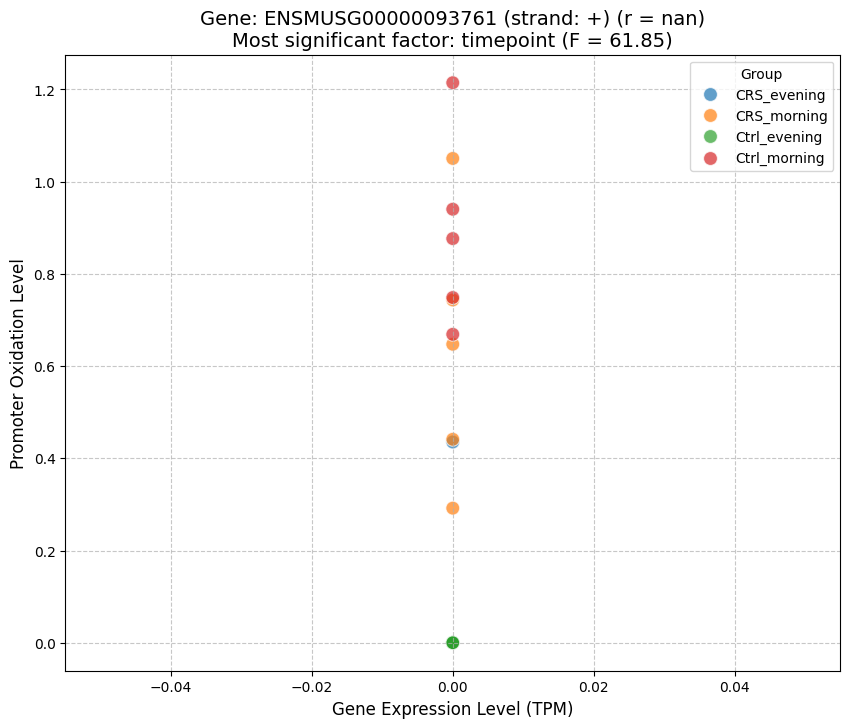

Plot saved to ../images/significant_gene_correlation_plots/ENSMUSG00000093761_+_promoter.png
Processing gene: ENSMUSG00000143378 (strand: +)
No direct match found for ENSMUSG00000143378, checking for partial matches...
Processing gene: ENSMUSG00000030793 (strand: +)


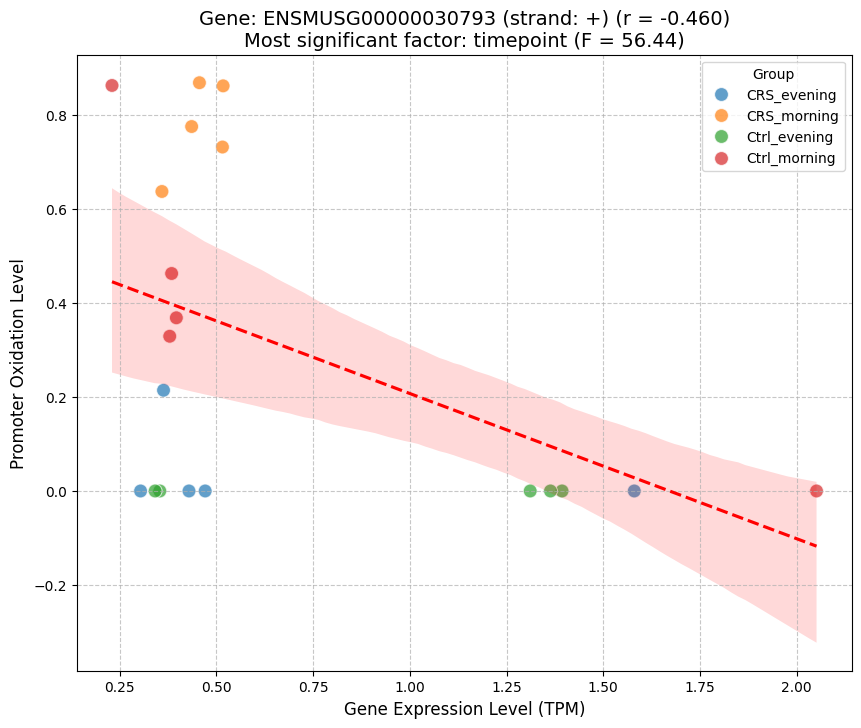

Plot saved to ../images/significant_gene_correlation_plots/ENSMUSG00000030793_+_promoter.png


In [16]:
expr_df, promoter_df, sig_bins_df = load_data()
significant_genes = load_significant_genes(sig_bins_df)
print(f"\nProcessing {len(significant_genes)} significant genes...")
    
# Store results
results = []
    
# Process each significant gene
for gene_info in significant_genes:
    try:
        result = plot_gene_correlation(gene_info, expr_df, promoter_df)
        if result:
            results.append(result)
    except Exception as e:
        print(f"Error processing gene {gene_info['gene_id']}: {e}")
        continue